## Remnants of "Space Game"

The graphics in Tempest are generated using Atari's 'Quadrascan' vector technology. The images are all defined using a series of vectors. A vector in this case is an `(x,y)` value pair that moves the beam in an x,y direction to a new point on the screen. A series of vectors moving from point to point around the screen will eventually form a complete image.

There are a bunch of different macros used to encode the vector commands that define the images. Most of the image definitions appear in `ALVROM.MAC`, and a few others in `ALDIS2.MAC`.


```
SPACG=0			;SUPPRESS SPACE GAME CODE
```

In [144]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points=""):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha)

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

## Unused Pictures in ALVROM.MAC

```
	.IF NE,SPACG
	.SBTTL ENEMY PICTURES
```

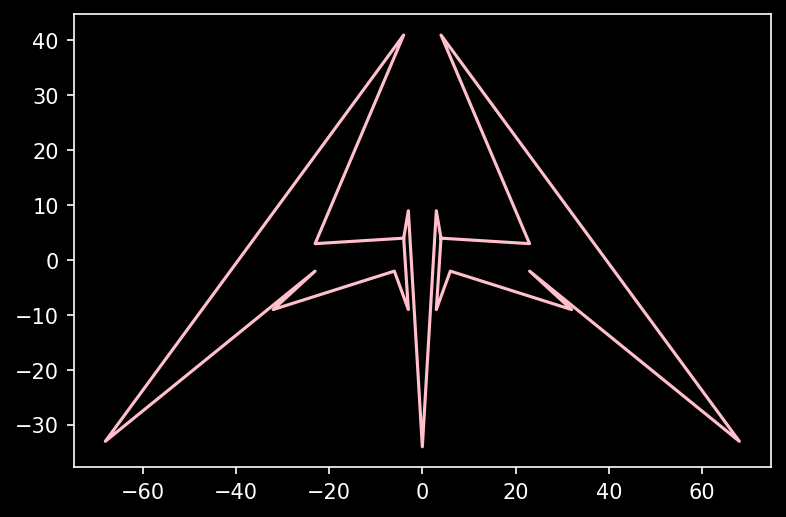

In [186]:
vector_data = """
ENER11:
	ICALVE
	CALVEC -4,4
	.BRITE=VARBRT
	CALVEC -17.,3
	CALVEC -4,29.
	CALVEC -44.,-21.
	CALVEC -17.,-2
	CALVEC -20.,-9
	CALVEC -6,-2
	CALVEC -3,-9
	CALVEC -4,4
	CALVEC -3,9
	CALVEC 0,-22.
	CALVEC 3,9
	CALVEC 4,4
	CALVEC 3,-9
	CALVEC 6,-2
	CALVEC 20.,-9
	CALVEC 17.,-2
	CALVEC 44.,-21.
	CALVEC 4,29.
	CALVEC 17.,3
	CALVEC 4,4
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


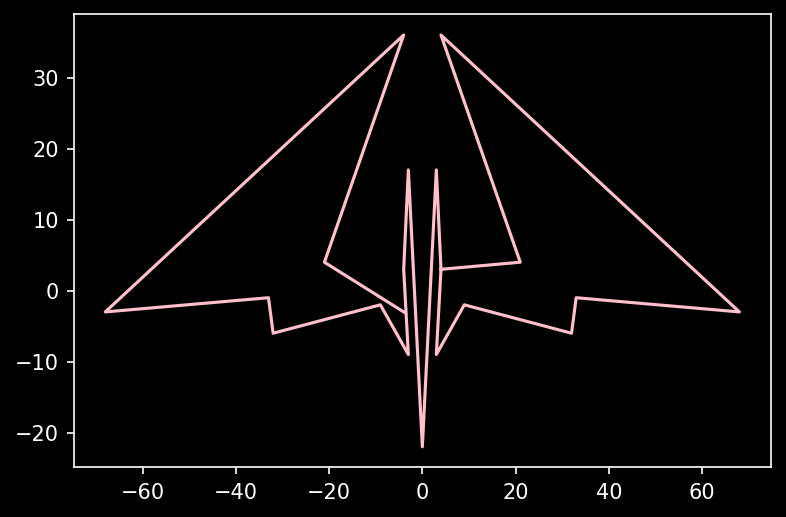

In [187]:
vector_data = """
ENER12:
	ICALVE
	CALVEC -4,-3
	.BRITE=VARBRT
	CALVEC -15.,4
	CALVEC -4,24.
	CALVEC -44.,-3
	CALVEC -21.,-1
	CALVEC -20.,-6
	CALVEC -9,-2
	CALVEC -3,-9
	CALVEC -4,3
	CALVEC -3,11.
	CALVEC 0,-16.
	CALVEC 3,11.
	CALVEC 4,3
	CALVEC 3,-9
	CALVEC 9,-2
	CALVEC 20.,-6
	CALVEC 21.,-1
	CALVEC 44.,-3
	CALVEC 4,24.
	CALVEC 15.,4
	CALVEC 4,3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


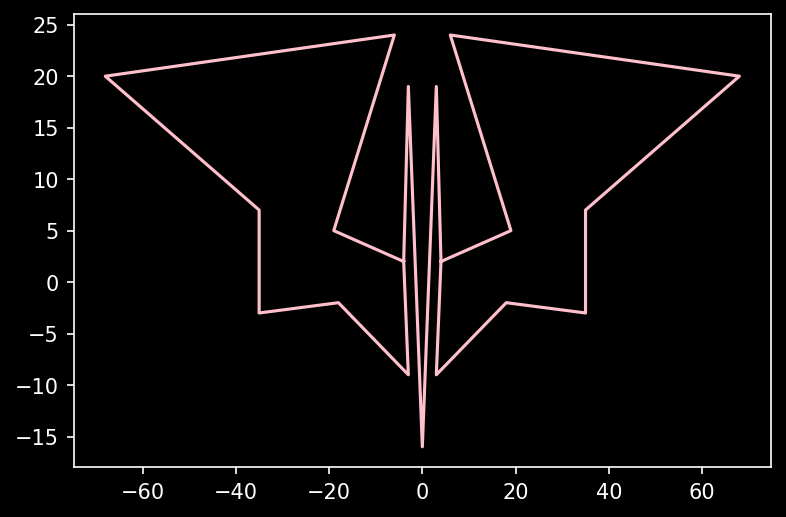

In [188]:
vector_data = """
ENER13:
	ICALVE
	CALVEC -4,2
	.BRITE=VARBRT
	CALVEC -13.,5
	CALVEC -6,18.
	CALVEC -44.,14.
	CALVEC -23.,7.
	CALVEC -23.,-3
	CALVEC -12.,-2
	CALVEC -3,-9
	CALVEC -4,2
	CALVEC -3,13.
	CALVEC 0,-10.
	CALVEC 3,13.
	CALVEC 4,2
	CALVEC 3,-9
	CALVEC 12.,-2
	CALVEC 23.,-3
	CALVEC 23.,7
	CALVEC 44.,14.
	CALVEC 6,18.
	CALVEC 13.,5
	CALVEC 4,2
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


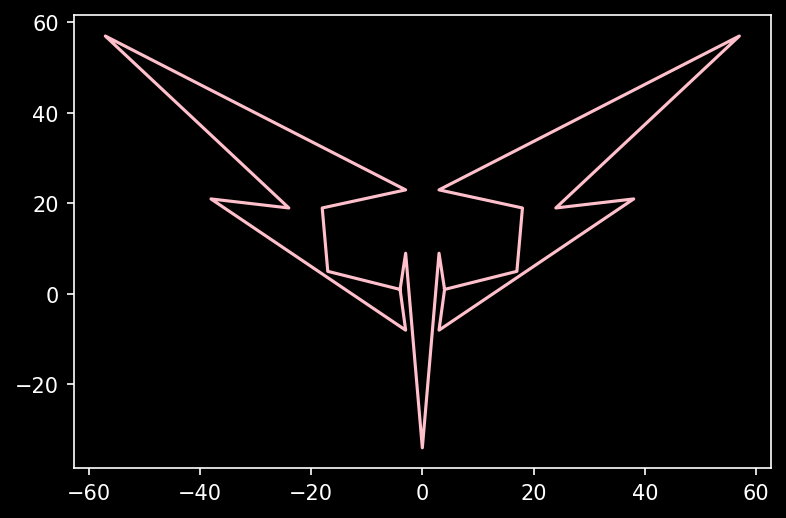

In [189]:
vector_data = """
ENER14:
	ICALVE
	CALVEC -4,1
	.BRITE=VARBRT
	CALVEC -11.,5
	CALVEC -12.,13.
	CALVEC -3,17.
	CALVEC -39.,39.
	CALVEC -18.,13.
	CALVEC -26.,15.
	CALVEC -3,-8
	CALVEC -4,1
	CALVEC -3,9
	CALVEC 0,-22.
	CALVEC 3,9
	CALVEC 4,1
	CALVEC 3,-8
	CALVEC 26.,15.
	CALVEC 18.,13.
	CALVEC 39.,39.
	CALVEC 3,17.
	CALVEC 12.,13.
	CALVEC 11.,5
	CALVEC 4,1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


[(0, 0, 'BLACK'), (-1, -3, 'BLACK'), (-1, -3, 'yellow'), (-4, 36, 'yellow'), (-36, 0, 'yellow'), (-18, -64, 'yellow'), (-32, -2, 'yellow'), (-21, 3, 'yellow'), (-16, -18, 'yellow'), (-18, 6, 'yellow'), (-5, 19, 'yellow'), (-3, -36, 'yellow'), (-1, -3, 'yellow'), (-1, -3, 'BLACK'), (1, -3, 'BLACK'), (1, -3, 'yellow'), (3, -36, 'yellow'), (5, 19, 'yellow'), (18, 6, 'yellow'), (16, -18, 'yellow'), (21, 3, 'yellow'), (32, -2, 'yellow'), (18, -64, 'yellow'), (36, 0, 'yellow'), (4, 36, 'yellow'), (1, -3, 'yellow'), (1, -3, 'BLACK'), (0, 0, 'BLACK')]
; X: 0  Y:0
; X: -1  Y:-3
; X: -1  Y:-3
; X: -4  Y:36
; X: -36  Y:0
; X: -18  Y:-64
; X: -32  Y:-2
; X: -21  Y:3
; X: -16  Y:-18
; X: -18  Y:6
; X: -5  Y:19
; X: -3  Y:-36
; X: -1  Y:-3
; X: -1  Y:-3
; X: 1  Y:-3
; X: 1  Y:-3
; X: 3  Y:-36
; X: 5  Y:19
; X: 18  Y:6
; X: 16  Y:-18
; X: 21  Y:3
; X: 32  Y:-2
; X: 18  Y:-64
; X: 36  Y:0
; X: 4  Y:36
; X: 1  Y:-3
; X: 1  Y:-3
; X: 0  Y:0


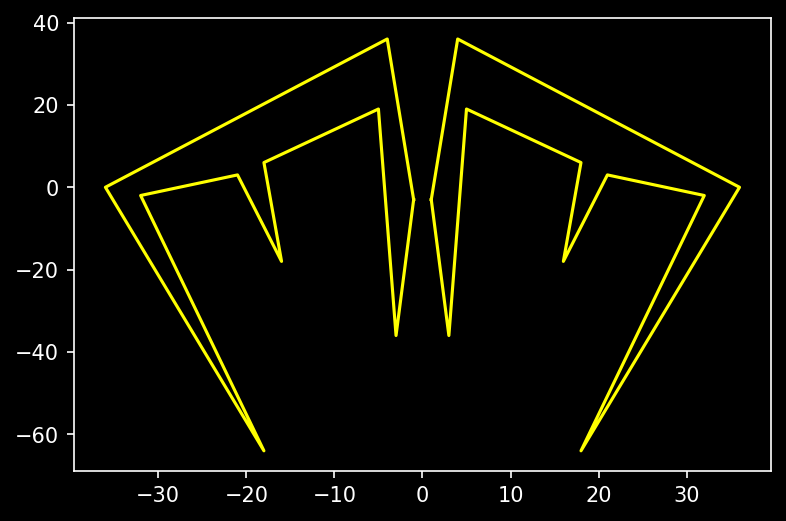

In [119]:
vector_data = """
ENER21:
	ICALVE
	CALVEC -1,-3
	.BRITE=VARBRT
	CALVEC -4,24.
	CALVEC -24.,0
	CALVEC -12.,-40.
	CALVEC -20.,-2
	CALVEC -15.,3
	CALVEC -10.,-12.
	CALVEC -12.,6
	CALVEC -5,13.
	CALVEC -3,-24.
	CALVEC -1,-3
	.BRITE=0
	CALVEC 1,-3
	.BRITE=VARBRT
	CALVEC 3,-24.
	CALVEC 5,13.
	CALVEC 12.,6
	CALVEC 10.,-12.
	CALVEC 15.,3
	CALVEC 20.,-2
	CALVEC 12.,-40.
	CALVEC 24.,0
	CALVEC 4,24.
	CALVEC 1,-3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)
print(vertices)
for x,y,_ in vertices:
    print(f"; X: {x}  Y:{y}")


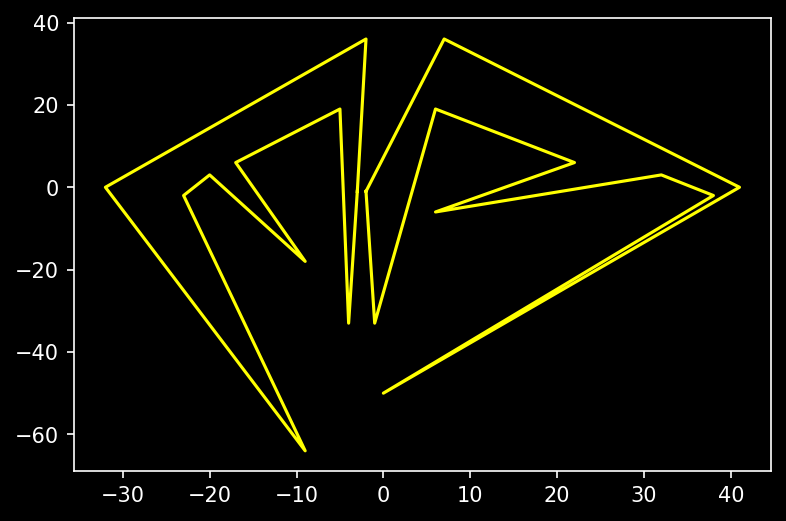

In [120]:
vector_data = """
ENER22:
	ICALVE
	CALVEC -3,-1
	.BRITE=VARBRT
	CALVEC -2,24.
	CALVEC -20.,0
	CALVEC -9,-40.
	CALVEC -17.,-2
	CALVEC -14.,3
	CALVEC -9,-12.
	CALVEC -11.,6
	CALVEC -5,13.
	CALVEC -4,-21.
	CALVEC -3,-1
	.BRITE=0
	CALVEC -2,-1
	.BRITE=VARBRT
	CALVEC 7,24.
	CALVEC 29.,0
	CALVEC 0,-32.
	CALVEC 26.,-2
	CALVEC 20.,3
	CALVEC 6,-6
	CALVEC 16.,6
	CALVEC 6,13.
	CALVEC -1,-21.
	CALVEC -2,-1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


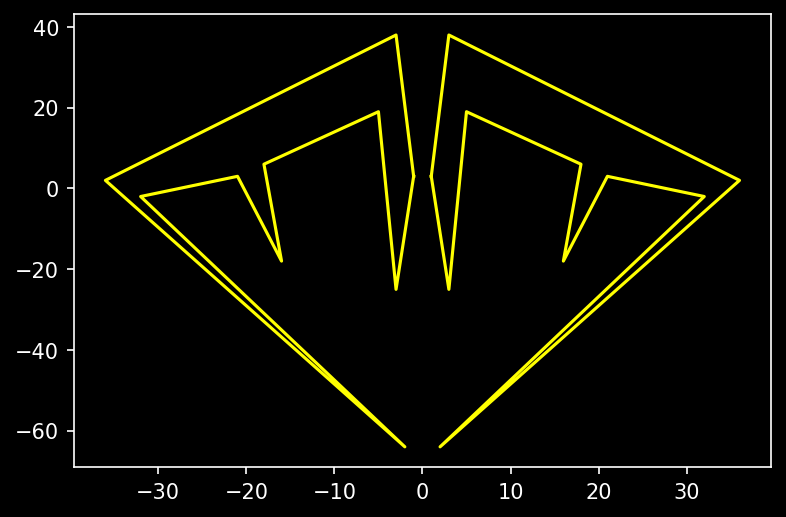

In [121]:
vector_data = """
ENER23:
    ICALVE
	CALVEC -1,3
	.BRITE=VARBRT
	CALVEC -3,26.
	CALVEC -24.,2
	CALVEC -2,-40.
	CALVEC -20.,-2
	CALVEC -15.,3
	CALVEC -10.,-12.
	CALVEC -12.,6
	CALVEC -5,13.
	CALVEC -3,-19.
	CALVEC -1,3
	.BRITE=0
	CALVEC 1,3
	.BRITE=VARBRT
	CALVEC 3,-19.
	CALVEC 5,13.
	CALVEC 12.,6
	CALVEC 10.,-12.
	CALVEC 15.,3
	CALVEC 20.,-2
	CALVEC 2,-40.
	CALVEC 24.,2
	CALVEC 3,26.
	CALVEC 1,3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


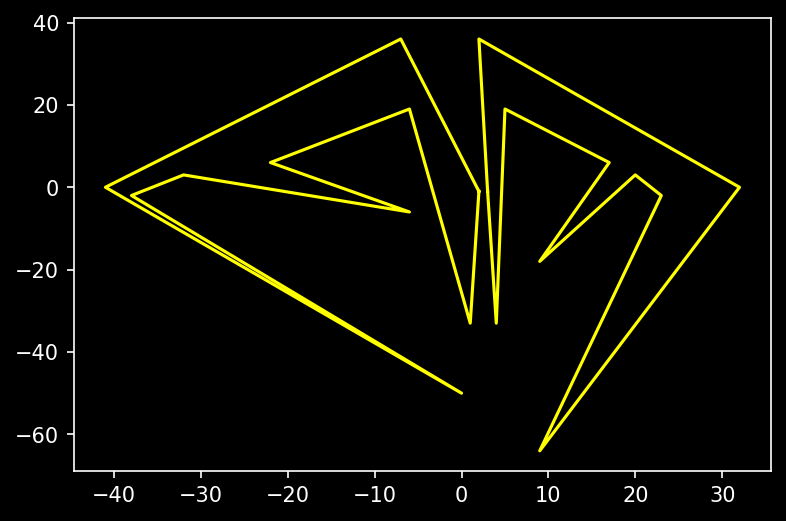

In [122]:
vector_data = """
ENER24:
	ICALVE
	CALVEC 2,-1
	.BRITE=VARBRT
	CALVEC -7,24.
	CALVEC -29.,0
	CALVEC 0,-32.
	CALVEC -26.,-2
	CALVEC -20.,3
	CALVEC -6,-6
	CALVEC -16.,6
	CALVEC -6,13.
	CALVEC 1,-21.
	CALVEC 2,-1
	.BRITE=0
	CALVEC 3,-1
	.BRITE=VARBRT
	CALVEC 2,24.
	CALVEC 20.,0
	CALVEC 9,-40.
	CALVEC 17.,-2
	CALVEC 14.,3
	CALVEC 9,-12.
	CALVEC 11.,6
	CALVEC 5,13.
	CALVEC 4,-21.
	CALVEC 3,-1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


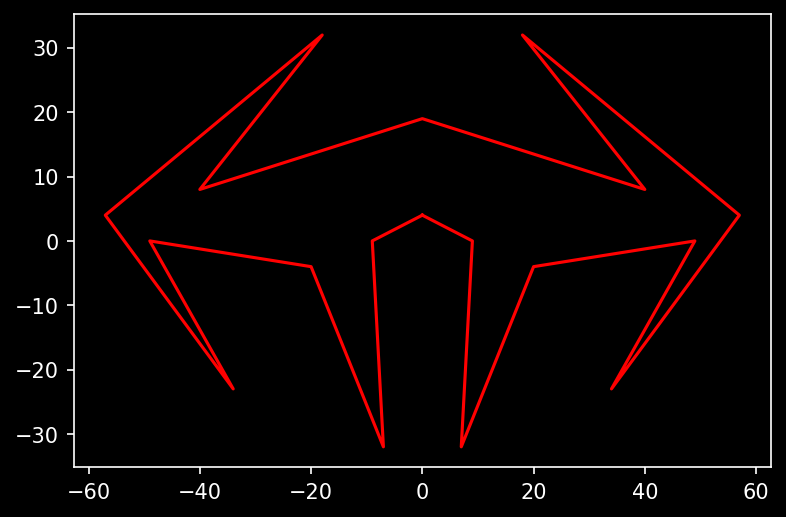

In [190]:
vector_data = """
ENER41:
	ICALVE
	CALVEC 0,4
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -14.,-4
	CALVEC -31.,0
	CALVEC -22.,-17.
	CALVEC -39.,4
	CALVEC -12.,20.
	CALVEC -28.,8
	CALVEC 0,13.
	CALVEC 28.,8
	CALVEC 12.,20.
	CALVEC 39.,4
	CALVEC 22.,-17.
	CALVEC 31.,0
	CALVEC 14.,-4
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,4
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


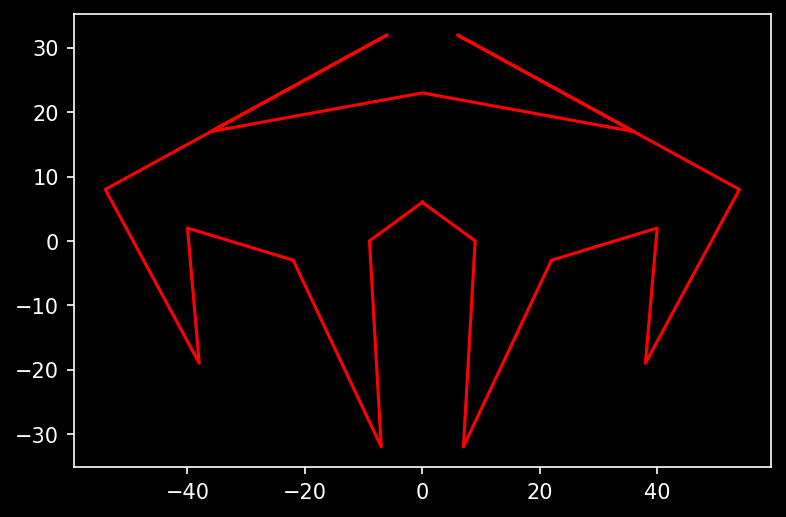

In [191]:
vector_data = """
ENER42:
	ICALVE
	CALVEC 0,6
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -16.,-3
	CALVEC -28.,2
	CALVEC -26.,-13.
	CALVEC -36.,8
	CALVEC -6,20.
	CALVEC -24.,11.
	CALVEC 0,17.
	CALVEC 24.,11.
	CALVEC 6,20.
	CALVEC 36.,8
	CALVEC 26.,-13.
	CALVEC 28.,2
	CALVEC 16.,-3
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,6
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


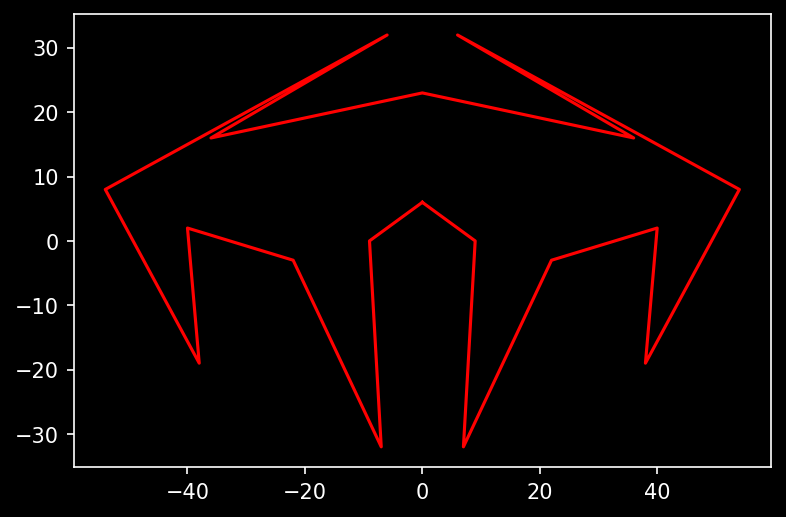

In [192]:
vector_data = """
ENER43:
	ICALVE
	CALVEC 0,6
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -16.,-3.
	CALVEC -28.,2
	CALVEC -26.,-13.
	CALVEC -36.,8
	CALVEC -6,20.
	CALVEC -24.,10.
	CALVEC 0,17.
	CALVEC 24.,10.
	CALVEC 6,20.
	CALVEC 36.,8
	CALVEC 26.,-13.
	CALVEC 28.,2
	CALVEC 16.,-3
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,6
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


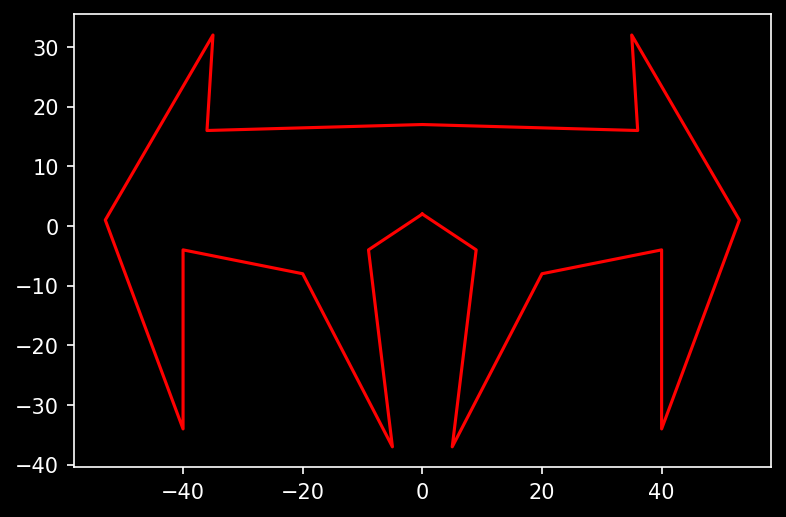

In [193]:
vector_data = """
ENER44:
	ICALVE
	CALVEC 0,2
	.BRITE=VARBRT
	CALVEC -9,-4
	CALVEC -5,-25.
	CALVEC -14.,-8
	CALVEC -28.,-4
	CALVEC -28.,-22.
	CALVEC -35.,1
	CALVEC -23.,20.
	CALVEC -24.,10.
	CALVEC 0,11.
	CALVEC 24.,10.
	CALVEC 23.,20.
	CALVEC 35.,1
	CALVEC 28.,-22.
	CALVEC 28.,-4
	CALVEC 14.,-8
	CALVEC 5,-25.
	CALVEC 9,-4
	CALVEC 0,2
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


```
	.IF NE,SPACG
	.WORD ENER11		;ROW 0 SEQUENCE	0
	.WORD ENER12		;		1
	.WORD ENER13		;		2
	.WORD ENER14		;		3
	.WORD ENER11		;ROW 1 SEQUENCE	0
	.WORD ENER12		;		1
	.WORD ENER13		;		2
	.WORD ENER14		;		3
	.WORD ENER21		;ROW 2 SEQUENCE	0
	.WORD ENER22		;		1
	.WORD ENER23		;		2
	.WORD ENER24		;		3
	.WORD ENER21		;ROW 3
	.WORD ENER22
	.WORD ENER23
	.WORD ENER24
	.WORD ENER41		;ROW 4 SEQUENCE	0
	.WORD ENER42		;		1
	.WORD ENER43		;		2
	.WORD ENER44		;		3
	.ENDC

```

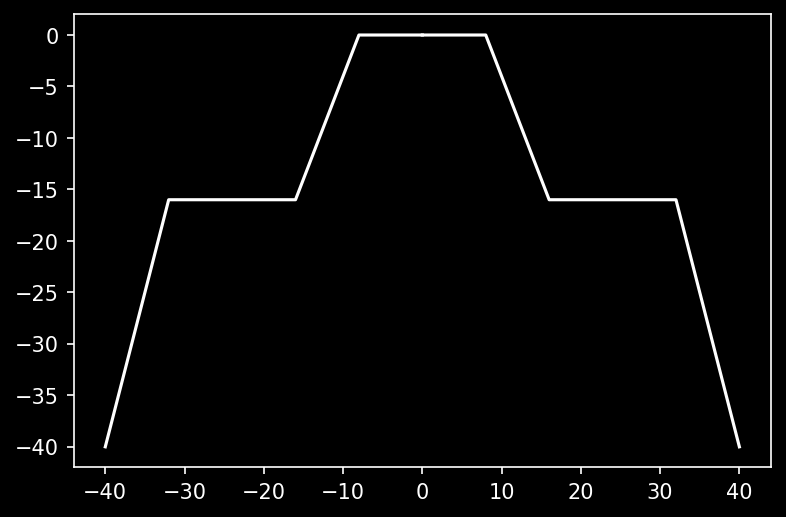

In [127]:
vector_data = """
GUNPIC:
    VCTR 0,0,6
    VCTR -8,0,6
	VCTR -8,-10,6
	VCTR -10,0,6
	VCTR -8,-18,6
	VCTR 50,0,0
	VCTR -8,18,6
	VCTR -10,0,6
	VCTR -8,10,6
	VCTR -8,0,6
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


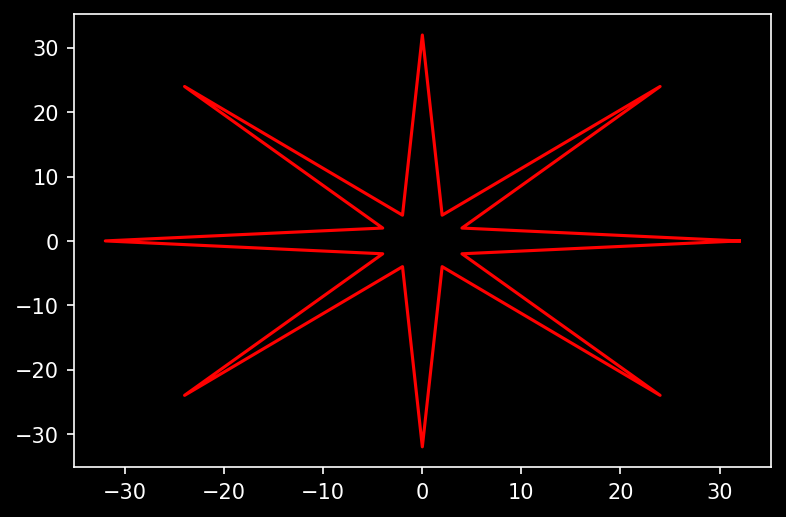

In [128]:
vector_data = """
EXPLOP:
	ICALVE
	.BRITE=0
	CALVEC 20.,0
	.BRITE=VARBRT
	CALVEC 4,2
	CALVEC 18.,18.
	CALVEC 2,4
	CALVEC 0,20.
	CALVEC -2,4
	CALVEC -18.,18.
	CALVEC -4,2
	CALVEC -20.,0
	CALVEC -4,-2
	CALVEC -18.,-18.
	CALVEC -2,-4
	CALVEC 0,-20.
	CALVEC 2,-4
	CALVEC 18.,-18.
	CALVEC 4,-2
	CALVEC 20.,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


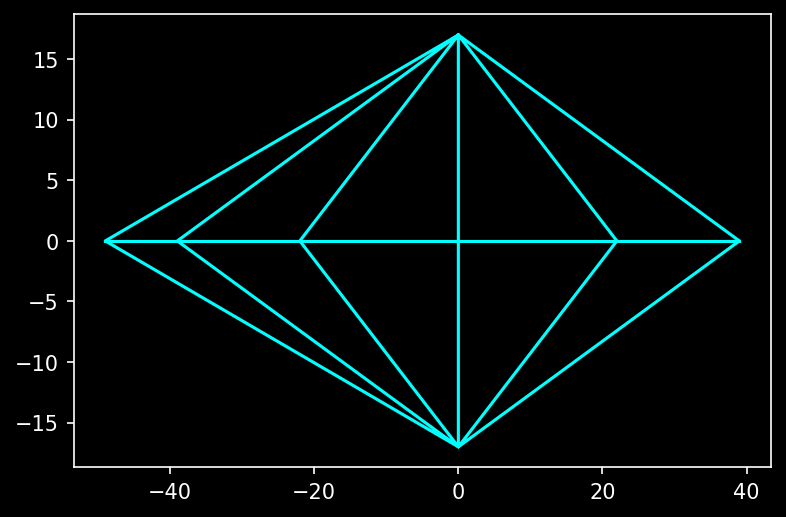

In [129]:
# HIGH=11
msauce_macro = """
.MACRO MSAUCE ...P1,...P2,...P3,...P4,...P5,...P6
	ICALVE
	CALVEC 0,.HIGH
	.BRITE=VARBRT
	CALVEC ...P1,0
	CALVEC 0,-.HIGH
	CALVEC ...P2,0
	CALVEC 0,.HIGH
	CALVEC ...P3,0
	CALVEC 0,-.HIGH
	CALVEC ...P4,0
	CALVEC 0,.HIGH
	CALVEC ...P5,0
	CALVEC 0,-.HIGH
	CALVEC ...P6,0
	CALVEC 0,.HIGH
	.BRITE=0
	CALVEC ...P6,0
	.BRITE=VARBRT
	CALVEC ...P1,0
	RTSL
"""

def_data = """
SAUPIC:	MSAUCE -31.,-27.,-16.,0,16.,27.
"""

def resolve_data(def_data):
    pic = msauce_macro
    pic = pic.replace("HIGH","11")
    parms = [x.replace('.','') for x in def_data.split()[2].split(',')]
    for i,x in enumerate(parms):
        pic = pic.replace(f"...P{i+1}",x)
    return pic

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


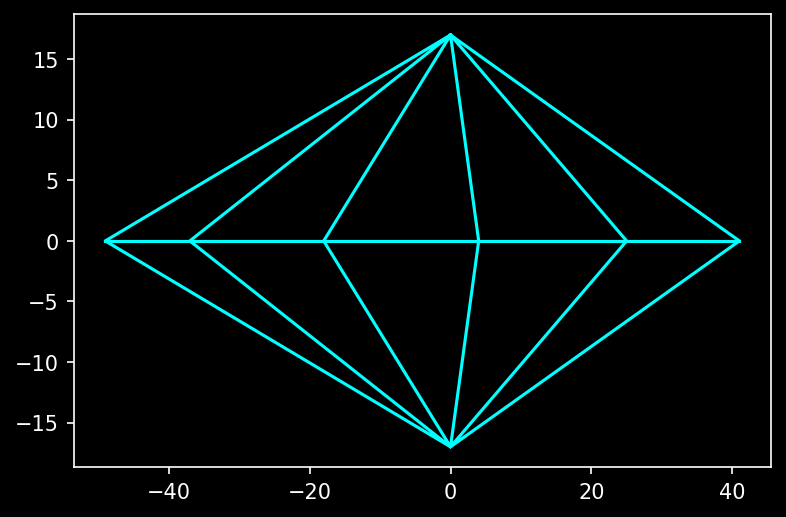

In [130]:
def_data = """
SA2PIC:	MSAUCE -31.,-25.,-12.,4,19.,29.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


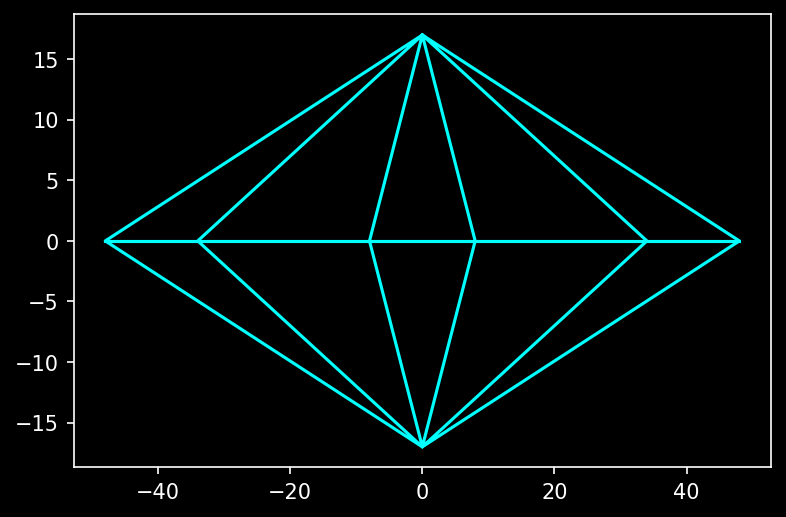

In [131]:
def_data = """
SA3PIC:
	MSAUCE -30.,-22.,-8,8,22.,30.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


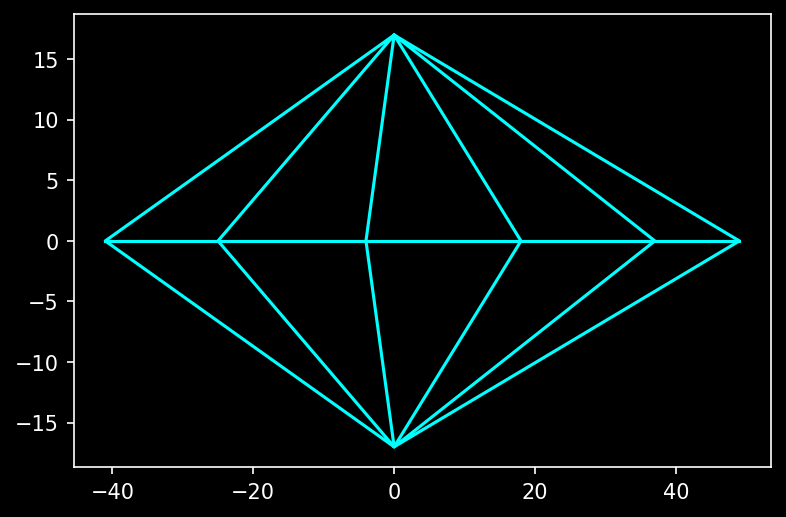

In [132]:
def_data = """
SA4PIC:
	MSAUCE -29.,-19.,-4,12.,25.,31.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


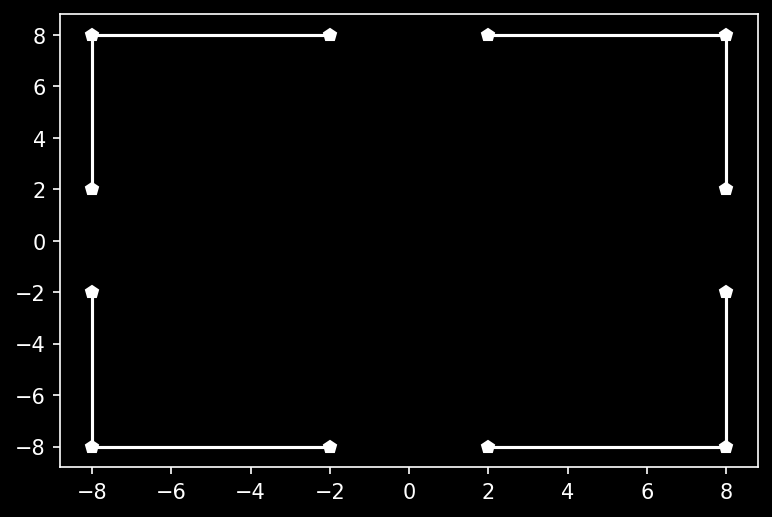

In [133]:
GURAD	="8"
GUBAR	="6"
GUBL	="4"
vector_data = """
GU2PIC:	
	CNTR
	VCTR GURAD,2,0
	VCTR 0,GUBAR,6
	VCTR -GUBAR,0,6
	VCTR -GUBL,0,0
	VCTR -GUBAR,0,6
	VCTR 0,-GUBAR,6
	VCTR 0,-GUBL,0
	VCTR 0,-GUBAR,6
	VCTR GUBAR,0,6
	VCTR GUBL,0,0
	VCTR GUBAR,0,6
	VCTR 0,GUBAR,6
	RTSL
""".replace("GUBAR",GUBAR).replace("GURAD",GURAD).replace("GUBL",GUBL)

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


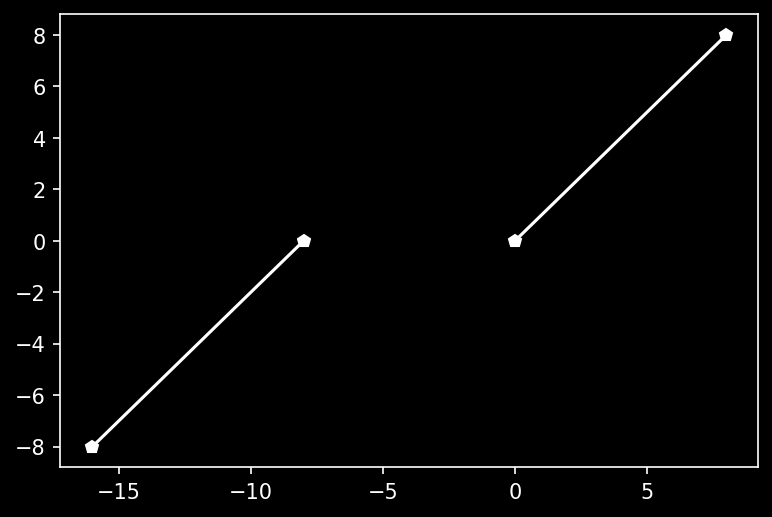

In [134]:
GURAD	=8
GUBAR	=6
GUBL	=4
vector_data = ("""
GU3PIC:
	CNTR
	VCTR GURAD,GURAD,0
	VCTR -2*GURAD,-2*GURAD,6
	VCTR 2*GURAD,0,0
	VCTR -2*GURAD,2*GURAD,6
	RTSL
""".replace("-2*GURAD",str(-1*GURAD))
   .replace("2*GURAD",str(-1*GURAD))
   .replace("GUBAR",str(GUBAR)).replace("GURAD",str(GURAD))
   .replace("GUBL",str(GUBL)))

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[21, 16, 14, 12]


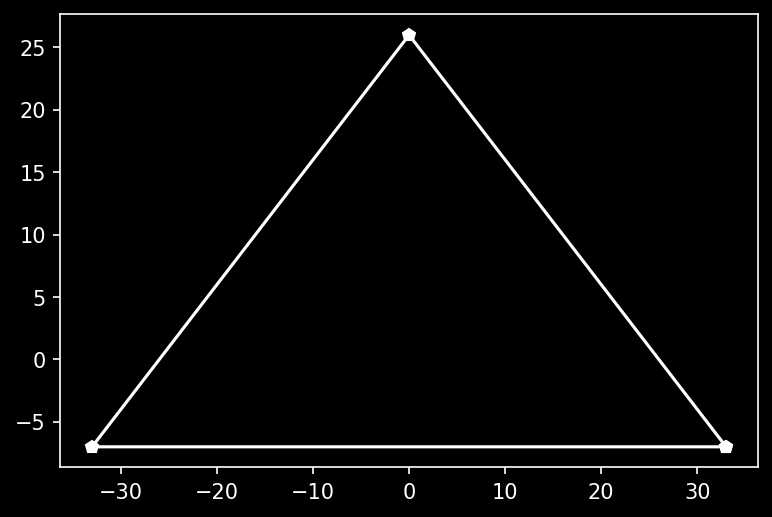

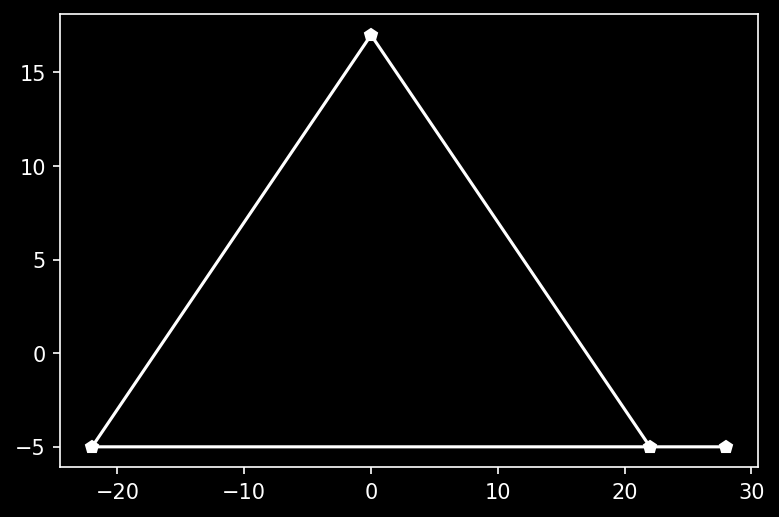

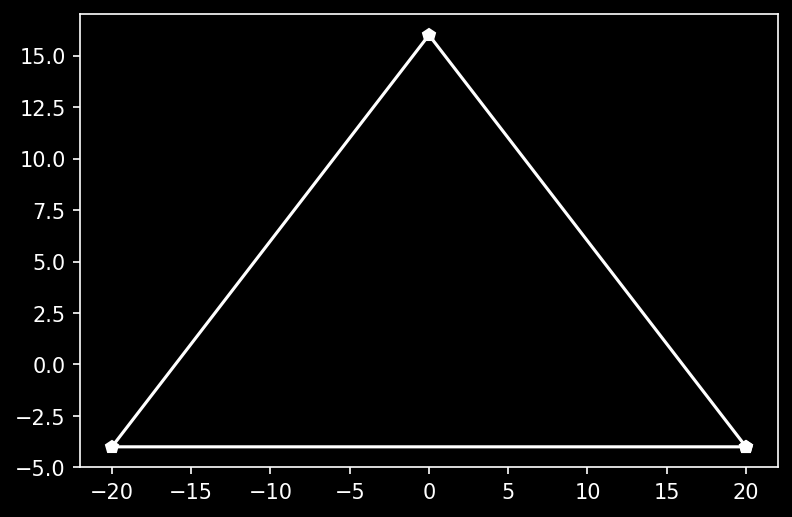

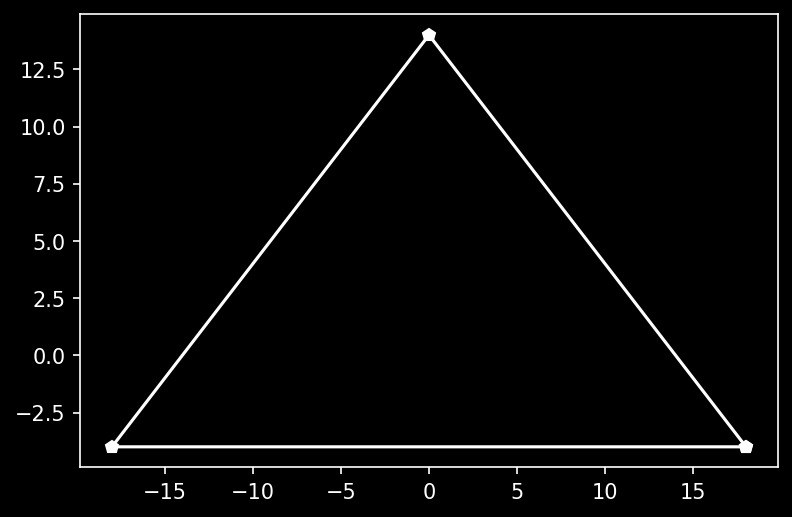

In [135]:

macro_data = """
.MACRO FORTMAC .FS
VCTR .FS,-<.FS/3>,0
VCTR -.FS,.FS,6
VCTR -.FS,-.FS,6
VCTR 2*.FS,0,6
VCTR -.FS,<.FS/3>,0
RTSL
.ENDM
.IF NE,0
"""

fort_data = """
FROW0: FORTMAC 15
FROW1: FORTMAC 10
FROW2: FORTMAC 0E
FROW3: FORTMAC 0C
"""
FSS = [int(x.split()[2],16) for x in fort_data.splitlines()[1:]]
print(FSS)
for FS in FSS:
    vector_data = (
        macro_data.replace("<.FS/3>", str(int(FS/3)))
       .replace("2*.FS", str(int(2*FS)))
       .replace(".FS", str(FS))
    )
    vectors = parse_vector_commands(vector_data,default_color="red")
    vertices = vectors_to_coords(vectors)
    plot_vertices(vertices,"p")


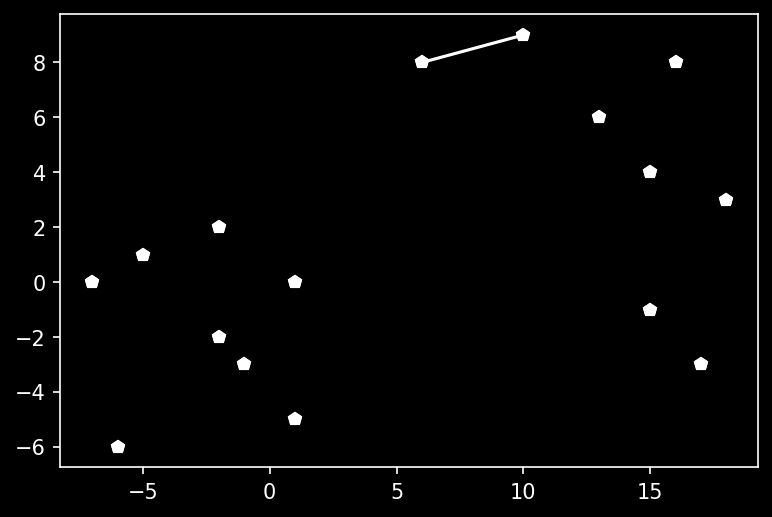

In [136]:
vector_data = """
SHRPIC:
	VCTR 1,0,0
	VDOT
	VCTR -3,2,0
	VDOT
	VCTR -3,-1,0
	VDOT
	VCTR -2,-1,0
	VDOT
	VCTR 1,-6,0
	VDOT
	VCTR 4,4,0
	VDOT
	VCTR 1,-1,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 0E,4,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 1,6,0
	VDOT
	VCTR -3,1,0
	VDOT
	VCTR -2,2,0
	VDOT
	VCTR 3,2,0
	VDOT
	VCTR -6,1,0
	VDOT
	VCTR -4,-1,6
	VDOT
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


```
	.IF NE,SPACG
	.WORD NOPTBL
	.WORD NOPTBL		;SAUCER
	.WORD DSHTBL		;DEF SPEAR
	.WORD ESHTBL		;ENEMY SPEAR PIC 1
	.WORD ES2TBL		;                2
	.WORD ES3TBL		;                3
	.WORD ES4TBL		;                4
	.WORD 0			;VERTICAL VP LINES (4)
	.WORD 0			;VERTICAL VP LINES (5)
	.WORD NOPTBL		;EXPLOSION PIC 1
	.WORD NOPTBL		;              2
	.WORD NOPTBL		;              3
	.WORD NOPTBL		;              4
	.WORD NOPTBL		;SAUCER PIC 2
	.WORD NOPTBL		;SAUCER PIC 3
	.WORD NOPTBL		;SAUCER PIC 4
	.WORD DS2TBL		;DEF SPEAR PIC 2
	.WORD DS3TBL		;DEF SPEAR PIC 3
	.WORD DS4TBL		;DEF SPEAR PIC 4
				;TABLE OF PTRS. TO OBJECT DRAW ROUTINES
	.WORD NOPTBL
	.WORD NOPTBL
	.WORD NOPTBL
	.WORD NOPTBL
	.WORD ASTTBL		;ASTEROID PICTURE
	.WORD NOPTBL		;GUN 2
	.ENDC
OBJTBL:
	.IF NE,SPACG
	.WORD GUNDRW
	.WORD SAUDRW
	.WORD DSHDRW
	.WORD ESHDRW
	.WORD ESHDRW
	.WORD ESHDRW
	.WORD ESHDRW
	.WORD VRT4DR
	.WORD VRT5DR
	.WORD EX1DRW
	.WORD EX2DRW
	.WORD EX3DRW
	.WORD EX4DRW
	.WORD SA2DRW
	.WORD SA3DRW
	.WORD SA4DRW
	.WORD DSHDRW
	.WORD DSHDRW
	.WORD DSHDRW
	.WORD SH1DRW
	.WORD SH2DRW
	.WORD SH3DRW
	.WORD SH4DRW
	.WORD ASTDRW
	.WORD GUNDR2
	.ENDC

```

```
	.IF NE,SPACG
NOPTBL:	.BYTE ENDNOP-NOPTBL
	.BYTE 0,0,0
ENDNOP:
DSHTBL:	.BYTE ENDDSH-DSHTBL
	.BYTE -2,0,2
	.BYTE 2,0,-2
	.BYTE -2,0,-2
	.BYTE 2,0,2
	.BYTE 0,2,0
	.BYTE 0,-2,0
ENDDSH:
DS2TBL:	.BYTE ENDDS2-DS2TBL
	.BYTE -2,1,1
	.BYTE 2,-1,-1
	.BYTE -2,-1,-1
	.BYTE 2,1,1
	.BYTE 0,1,-1
	.BYTE 0,-1,1
ENDDS2:
DS3TBL:	.BYTE ENDDS3-DS3TBL
	.BYTE -2,2,0
	.BYTE 2,-2,0
	.BYTE -2,-2,0
	.BYTE 2,2,0
	.BYTE 0,0,-2
	.BYTE 0,0,2
ENDDS3:
DS4TBL:	.BYTE ENDDS4-DS4TBL
	.BYTE -2,1,-1
	.BYTE 2,-1,1
	.BYTE -2,-1,1
	.BYTE 2,1,-1
	.BYTE 0,-1,-1
	.BYTE 0,1,1
ENDDS4:
ESHTBL:	.BYTE ENDESH-ESHTBL
	.BYTE 0,-5,0
	.BYTE 2,5,0
	.BYTE -1,5,2
	.BYTE -1,5,-2
ENDESH:
ES2TBL:	.BYTE EN2ESH-ES2TBL
	.BYTE 0,-5,0
	.BYTE 2,5,1
	.BYTE -2,5,1
	.BYTE 0,5,-2
EN2ESH:
ES3TBL:	.BYTE EN3ESH-ES3TBL
	.BYTE 0,-5,0
	.BYTE 1,5,2
	.BYTE -2,5,0
	.BYTE 1,5,-2
EN3ESH:

ES4TBL:	.BYTE EN4ESH-ES4TBL
	.BYTE 0,-5,0
	.BYTE 0,5,2
	.BYTE -2,5,-1
	.BYTE 2,5,-1
EN4ESH:
ASTTBL:	.BYTE ENDAST-ASTTBL
	.BYTE -6,0,0
	.BYTE 3,5,4
	.BYTE 3,5,-4
	.BYTE 0,-5,0
ENDAST:
	.ENDC

```

```
	.IF NE,SPACG
SAUDRW:
	TLABS 0
	TJSR CSAURT
	OBJEND

SA2DRW:	TLABS 0
	TJSR CSAUR2
	OBJEND
SA3DRW:	TLABS 0
	TJSR CSAUR3
	OBJEND
SA4DRW:	TLABS 0
	TJSR CSAUR4
	OBJEND
GUNDRW:	TLABS 0
	TSCAL 0
	TJSR CGUNRT
	OBJEND

GUNDR2:	TLABS 0
	TSCAL 0
	TJSR CGUNR2
	OBJEND
	
EX1DRW:
	TLABS 0
	TSCAL 3
	TJSR CEXPRT
	OBJEND

EX2DRW:
	TLABS 0
	TSCAL 2
	TJSR CEXPRT
	OBJEND

EX3DRW:
	TLABS 0
	TSCAL 1
	TJSR CEXPRT
	OBJEND

EX4DRW:
	TLABS 0
	TSCAL 0
	TJSR CEXPRT
	OBJEND
	CSAURT=0
	CGUNRT=1
	CEXPRT=2
	CSAUR2=3
	CSAUR3=4
	CSAUR4=5
	CSHRAP=6
	CGUNR2=7
	.ENDC
```

```
JSRTAB:
	.IF NE,SPACG
	.WORD SAUPIC
	.WORD GU2PIC
	.WORD EXPLOP
	.WORD SA2PIC
	.WORD SA3PIC
	.WORD SA4PIC
	.WORD SHRPIC
	.WORD GU3PIC
	.ENDC
```

```
	.SBTTL OBJECT TABLE-CONNECTIONS
	.RADIX 16
	.IF NE,SPACG
ESHDRW:	TLABS 0
	SBRITE 0E0
	TVCTR 1
	SBRITE 0
	TVCTR 0
	SBRITE 0E0
	TVCTR 2
	SBRITE 0
	TVCTR 0
	SBRITE 0E0
	TVCTR 3
	OBJEND
DSHDRW:	TLABS 0
	SBRITE 0E0
	TVCTR 1
	SBRITE 0
	TVCTR 2
	SBRITE 0E0
	TVCTR 3
	SBRITE 0
	TVCTR 4
	SBRITE 0E0
	TVCTR 5
	OBJEND
SH1DRW:
	TLABS 0
	TSCAL 3
	TJSR CSHRAP
	OBJEND
SH2DRW:
	TLABS 0
	TSCAL 2
	TJSR CSHRAP
	OBJEND
SH3DRW:
	TLABS 0
	TSCAL 1
	TJSR CSHRAP
	OBJEND
SH4DRW:
	TLABS 0
	TSCAL 0
	TJSR CSHRAP
	OBJEND
ASTDRW:
	TLABS 0
	SBRITE 0E0
	TVCTR 1
	TVCTR 2
	TVCTR 3
	TVCTR 0
	TVCTR 2
	SBRITE 0
	TVCTR 3
	SBRITE 0E0
	TVCTR 1
	OBJEND
	.PAGE
	.SBTTL DRAW TABLES:GRID LINES
VRT4DRW:
VRT5DRW:			;DRAW 5 VERT LINES
	TLABS 0
	SBRITE 040
	TVCTR 1
	SBRITE 0
	TVCTR 3
	SBRITE 040
	TVCTR 2
	SBRITE 0
	TVCTR 4
	SBRITE 040
	TVCTR 5
	SBRITE 0
	TVCTR 7
	SBRITE 040
	TVCTR 6
	SBRITE 0
	TVCTR 8
	SBRITE 040
	TVCTR 9
	OBJEND
	.ENDC
```

## Space Game in ALCOMN.MAC

```
	.IF NE,SPACG
NEXPLO	=10
NENESH	=4
NDEFSH	=4
NSAUCE	=1
NFORTS	=4
NEROWS	=5
NECOLS	=8
NBALLS	=4
NSHRAP	=2
NASTER	=4
	.ENDC
```

```
	.IF NE,SPACG

;OBJECT SIZES (FOR COLLISION DETECTION)
;
IRIE	=IRNGX/32.		;ENEMY RADIUS
IRIG	=IRIE			;GUN	"
IRIS	=IRIE			;SAUCER	"
IRIF	=10			;FORTRESS
IRISP	=IRIE/4			;SPEAR	"
	.PAGE
	.SBTTL CONSTANTS-PLAYFIELD PARAMETERS


					;ENEMY COLUMNS:
ICOLMAX	=IHIX-<2*IRIE>			;	MAX X (WC)
ICOLMIN	=ILOX+<2*IRIE>			;	MIN X (WC)

ILIVES	=4			;INITIAL # OF LIVES GIVEN TO PLAYER
IESZ	=80			;INITIAL ENEMY HEIGHT (WC)
IGXMIN	=ICOLMIN+<IRIE*2>	;MINIMUM X VALUE FOR GUN
IGXMAX	=ICOLMAX-<IRIE*2>	;MAXIMUM X VALUE FOR GUN

					;GUN:
IGXINC	=<<IGXMAX-IGXMIN>/<3*FPS>>	;	X INCREMENT/FRAME

IGX	=<IGXMAX+IGXMIN>/2	;INITIAL GUN COORDINATES (WC)
IGY	=ILOY+<IRIG*2>
IGZ	=IESZ

ISAUCY	=IHIY-<IRIS*2>		;INITIAL SAUCER COORDINATES (WC)
ISAUCZ	=IESZ

IFORTX	=IGXMAX-IRIG-IRIF	;INITIAL FORTRESS POSITION (RIGHTMOST)(WC)
IFORTY	=IGY+IRIG+IRIF+IRIE
IFORTZ	=IESZ
IFORTS	=7E			;INITIAL FORT STATUS
IXDFFCC	=<IRNGX-<2*<IHIX-IFORTX>>>/<NFORTS-1>	;FORT SEPARATION
IFORADI	=IRIF			;FORTRESS RADIUS

IROWL	=0FF			;INITIAL ENEMY ROW STATUS
IXCOLS	=IFORTX			;X COORDINATE (WC) OF UPPER RIGHT ENEMY IN
IZCOLS	=IESZ			;A NEWLY INITIALIZED ARRAY
IYROW1	=ISAUCY-IRIS-IRIE-IRIE	;Y COORDINATE (WC) OF UPPER RIGHT ENEMY IN
				;A NEWLY INITIALIZED 1ST WAVE
IXDEECC	=IRIE*5/2		;ENEMY ENEMY CENTER CENTER DELTA (X)
IYDEECC	=IRIE*3			;  "	"	"     "      "   (Y)
ICOLINC	=1			;ENEMY COLUMN & ROW INITIAL INCREMENTS
IROWINC	=IRIE
ITIMSAU	=0C0			;INITIAL VAUE FOR TIMSAU
ITIMEXP	=1			;INITIAL VALUE FOR TIMEXP
ITIMXP	=5			;# OF FRAME UPDATES FOR EACH BANG

ITIMGUP	=0			;INITIAL VALUE FOR TIMGUP
ITAUTOF	=1			;INITIAL VALUE FOR TAUTOF
ITIMESP	=4			;INITIAL VALUE FOR TIMESP
FPS	=30.			;FRAMES/SEC

					;SAUCER:
ISAXMAX	=IHIX-IRIS			;	MAXIMUM X (WC)
ISAXMIN	=ILOX+IRIS			;	MINIMUM X (WC)
ISAXINC	=<<ISAXMAX-ISAXMIN>/<5*FPS>> 	;	X INCREMENT/FRAME

					;SPEARS:
IDSXMIN	=ISAXMIN
IDSXMAX	=ISAXMAX
IDSXINC	=4
IESXRA	=2			;X,Y,Z RADU FOR EACH OBJECT TYPE
IESYRA	=7
IESZRA	=2
IDSXRA	=1
IDSYRA	=4
IDSZRA	=1
ISAXRA	=0C
ISAYRA	=8
ISAZRA	=08
IENXRA	=6
IENYRA	=8
IENZRA	=6
IASXRA	=5
IASYRA	=7
IASZRA	=5
IDSYMAX	=ISAUCY+IRIS			;	DEFENSIVE SPEAR MAX Y (WC)
IESYMIN	=IGY				;	ENEMY SPEAR MIN Y (WC)
IDSYINC	=<<IDSYMAX-IESYMIN>/<1*FPS>>	;	DEF SPEAR INCREMENT/FRAME
IESYINC	=IDSYINC/2			;	ENEMY SPEAR INCREMENT/FRAME


IASXMAX	=IHIX-IASXRA-2		;ASTEROIDS
IASXMIN	=IASXRA+3
IASZMAX	=IHIY-IASZRA-2
IASZMIN	=IASZRA+3
				;EYE:
IEYL	=20			;WORLD COORDINATE Y (NEGATIVE)
IEZL	=080			;WORLD COORDINATE Z
	
IEYEFAC	=2			;EYE FACTOR POWER OF 2 MULTIPLIER
IXDOTD	=8			;X,Y, & Z DELTA BETWEN DOTS IN CUBE
IYDOTD	=8
IZDOTD	=8
	.ENDC
```

```
	.IF NE,SPACG

				;DYNAMIC PICTURE CODES (INDEX ANITAB)
CGUPIC	=0
CSAUCPI	=1
CESPIC	=3
CDSPIC	=2
CEXPIC	=4
CBAPIC	=0
CSHPIC	=5
CASPIC	=6

	.SBTTL CONSTANTS-EXPLOSION CODES

				;EXPLOSION CODES:
CBNGSS	=0			;	SPEAR SPEAR
CBNGSC	=1			;	SPEAR SAUCER
CBNGEN	=2			;	SPEAR ENEMY
CBNGUN	=3			;	SPEAR GUN
	.ENDC
```

```
	.IF NE,SPACG

	.SBTTL VARIABLES-OBJECT TIMERS, INCREMENTS

ATGUND:	.BLKB 1			;AUTO GUN DIRECTION (-LEFT; +RIGHT)
TAUTOF:	.BLKB 1			;AUTO FIRE GUN TIMER
SAUCDR:	.BLKB 1			;SAUCER DIRECTION
TIMGUP:	.BLKB 1			;GUN UPDATE TIMER
TIMSAU:	.BLKB 1			;SAUCER TIMER
TIMEXP:	.BLKB 1			;EXPLOSION UPDATE TIMER
TIMEPO:	.BLKB 1			;ENEMY POSITION UPDATE TIMER
	.PAGE
	.SBTTL VARIABLES-ENEMY
				;
				;ENEMY STATUS BITS= 0=DEAD, 1=ALIVE
				;	2 BYTES/ROW
				;	D0 -> D7=LEFT TO RIGHT IN ROW
				;	ROWL -> ROWL+5=BOTTOM TO TOP ROW

TROWL:	.BLKB 1			;TEMP STORAGE FOR ROWL
FONSCR:	.BLKB 1			;FLAG FOR ENEMY ON SCREEN IN ROW
ANISEQ:	.BLKB 1			;ENEMY POSITION (0,1,2 OR 3)-USED TO DEDUCE
				;WHICH PICTURE TO DISPLAY

ROWLOR:	.BLKB 1			;OR'D ROWL ARRAYS

FORTST:	.BLKB NFORTS*4		;FORTRESS STATII



NUENSH:	.BLKB 1			;# ENEMY SHOTS IN AIR
NUMBNG:	.BLKB 1			;# EXPLOSIONS

	.ENDC
```

```
	.IF NE,SPACG
THSZL:	.BLKB 1			;GRID DISPLAY:TEMP SZL & H FOR FAR ENDPT
THSZH:	.BLKB 1
CONTR1:	.BLKB 1			;COUNTERS
CONTR2:	.BLKB 1
RANGEX:	.BLKB 1			;RANGE FOR COLLISION
RANGEY:	.BLKB 1
RANGEZ:	.BLKB 1
ASTOLA:	.BLKB 1			;# OF ASTEROIDS TO BE LAUNCHED
SENEMR:	.BLKB 1			;ROW & CLUMN # OF ENEMY IN SMART TARGET WINDOW
SENEMC:	.BLKB 1			;(- IF NONE)
SENEMY:	.BLKB 1			;INDEX OF ENEMY OBJECT IN SMART TARGET WINDOW
DELTX:	.BLKB 1
DELTY:	.BLKB 1
DELTZ:	.BLKB 1
DELTXL:	.BLKB 1
DELTYL:	.BLKB 1
DELTZL:	.BLKB 1
ABSZDE:	.BLKB 1
ABSXDE:	.BLKB 1
	.PAGE
	.SBTTL VARIABLES-OBJECT WORLD COORDINATES, PICTURES

	.ASECT
	.=100
OCNTXL:
GX:	.BLKB 1
SAUCX:	.BLKB NSAUCE
ESX:	.BLKB NENESH
DSX:	.BLKB NDEFSH
EXPLX:	.BLKB NEXPLO
BALLX:	.BLKB NBALLS
SHX:	.BLKB NSHRAP
ASX:	.BLKB NASTER
FORTX:	.BLKB NFORTS
	
OCNTYL:
GY:	.BLKB 1
SAUCY:	.BLKB NSAUCE
ESY:	.BLKB NENESH
DSY:	.BLKB NDEFSH
EXPLY:	.BLKB NEXPLO
BALLY:	.BLKB NBALLS
SHY:	.BLKB NSHRAP
ASY:	.BLKB NASTER
FORTY:	.BLKB NFORTS
	
OCNTZL:
GZ:	.BLKB 1
SAUCZ:	.BLKB NSAUCE
ESZ:	.BLKB NENESH
DSZ:	.BLKB NDEFSH
EXPLZ:	.BLKB NEXPLO
BALLZ:	.BLKB NBALLS
SHZ:	.BLKB NSHRAP
ASZ:	.BLKB NASTER
FORTZ:	.BLKB NFORTS
	
OBJPIC:
GPIC:	.BLKB 1
SAUCPIC:.BLKB NSAUCE
ESPIC:	.BLKB NENESH
DSPIC:	.BLKB NDEFSH
EXPLPI:	.BLKB NEXPLO
BALLPI:	.BLKB NBALLS
SHPIC:	.BLKB NSHRAP
ASPIC:	.BLKB NASTER
	.ENDC
```

```
	.IF NE,SPACG
;SFORTS:.BLKB NFORTS*4*2	;SAVE AREA FOR EACH PLAYER'S FORTSTATUS
	.ASECT
	.=2A0
BUFR8:	.BLKB 8			;BUFFER
INDEX0:	.BLKB 1
SDOT:	.BLKB 8*8		;DOT STATUS
XDOT:	.BLKB 8			;X PLANE LOCS
YDOT:	.BLKB 8			;Y PLANE LOCS
ZDOT:	.BLKB 8			;Z PLANE LOCS
RIGHT:	.BLKB 1
LEFT:	.BLKB 1
HIGH:	.BLKB 1
LOW:	.BLKB 1
XHIVIS:	.BLKB 1			;HIGHEST VISIBLE PX FOR GIVEN P4
XLOVIS:	.BLKB 1			;LOWEST VISIBLE PX FOR GIVEN P4
ZHIVIS:	.BLKB 1			;HIGHEST VISIBLE PZ FOR GIVEN P4
ZLOVIS:	.BLKB 1			;LOWEST VISIBLE PZ FOR GIVEN P4
RITDLT	=PNTTBL			;SX,SZ VECTOR FOR MOVING RIGHT
LEFDLT	=PNTTBL+4		;SX,SZ VECTOR FOR MOVING LEFT
UPDLT	=PNTTBL+8		;SX,SZ VECTOR FOR MOVING UP
	.ASECT
	.=2A0
ASXINL:	.BLKB NASTER
ASXIN:	.BLKB NASTER
ASYINL:	.BLKB NASTER
ASYIN:	.BLKB NASTER
ASZINL:	.BLKB NASTER
ASZIN:	.BLKB NASTER
ASTYPE:	.BLKB 1
DSTYPE:	.BLKB NDEFSH		;DEF SPEAR TYPE
				;FF=NO TARGET
				;D7=0: D6-D0=INDEX #
				;D7=1: D2-D0=ROW #
				;      D5-D3=COLUMN #
				;      D6=0
ASXL:	.BLKB NASTER
ASYL:	.BLKB NASTER
ASZL:	.BLKB NASTER
	.ASECT
	.=320
FZCOLS:	.BLKB NECOLS	
FXCOLS:	.BLKB NECOLS		;FRACTIONAL POSITION
FYROWS:	.BLKB NEROWS
FZROWS:	.BLKB NEROWS
ROTCNT:	.BLKB 1
XRCNTR:	.BLKB 1			;ROTATION CENTER
YRCNTR:	.BLKB 1
ZRCNTR:	.BLKB 1
PLAYST:
ZDEECC:	.BLKB 1
XDEECC:	.BLKB 1
ZCOLS:	.BLKB NECOLS
ZROWS:	.BLKB NEROWS
XCOLS:	.BLKB NECOLS
YROWS:	.BLKB NEROWS
ROWL:	.BLKB NEROWS
COLINC:	.BLKB 1
ROWINC:	.BLKB 1
NUMENE:	.BLKB 1
PLAYEND:
SAVEST:	.BLKB PLAYEND-PLAYST	;SAVE AREA FOR PLAYER WAITING
	.ENDC
```

```
	.IF NE,SPACG
	.SBTTL MACROS: ARITHMETIC

	.MACRO APBCDD AA,BB,CC	;A+B TO C (DOUBLE PREC)

	LDA AA
	CLC
	ADC BB
	STA CC
	LDA AA+1
	ADC BB+1
	STA CC+1

	.ENDM

	.MACRO AMBCDD AA,BB,CC	;A-B TO C (DOUBLE PREC)

	LDA AA
	SEC
	SBC BB
	STA CC
	LDA AA+1
	SBC BB+1
	STA CC+1

	.ENDM
	.MACRO APBCSD AA,BB,CC	;A+B->C (S+S->D)
	LDA AA
	CLC
	ADC BB
	STA CC
	LDA I,0
	ADC I,0
	STA CC+1

	.ENDM

	.MACRO APBCSS AA,BB,CC 	;A+B -> C (SINGLE PREC)
	LDA AA
	CLC
	ADC BB
	STA CC

	.ENDM

	.MACRO AMBCSS AA,BB,CC	;A-B -> C (SINGLE PREC)

	LDA AA
	SEC
	SBC BB
	STA CC

	.ENDM

;
;A+B -> A A=MAX IF A+B > MAX
;CC IF AT LIMIT

	.MACRO APBMAX AA,BB,MAX
	LDA AA
	CLC
	ADC I,BB
	CMP I,MAX
	IFCS
	LDA I,MAX
	CLC
	ELSE
	SEC
	ENDIF
	STA AA
	.ENDM

;A-B -> A A=MIN IF A-B < MIN
;CC IF AT LIMIT

	.MACRO AMBMIN AA,BB,MIN
	LDA AA
	SEC
	SBC I,BB
	CMP I,MIN
	IFCC
	LDA I,MIN
	ENDIF
	STA AA
	.ENDM
	.ENDC
```